In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!wget https://bitbucket.org/ishaanjav/code-and-deploy-custom-tensorflow-lite-model/raw/a4febbfee178324b2083e322cdead7465d6fdf95/fruits.zip

--2025-10-14 12:35:06--  https://bitbucket.org/ishaanjav/code-and-deploy-custom-tensorflow-lite-model/raw/a4febbfee178324b2083e322cdead7465d6fdf95/fruits.zip
Resolving bitbucket.org (bitbucket.org)... 104.192.142.26, 104.192.142.24, 104.192.142.25, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.142.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105946856 (101M) [application/zip]
Saving to: ‘fruits.zip’

fruits.zip          100%[===================>] 101.04M  17.1MB/s    in 6.2s    

2025-10-14 12:35:14 (16.4 MB/s) - ‘fruits.zip’ saved [105946856/105946856]



In [8]:
!unzip fruits.zip

Archive:  fruits.zip
replace __MACOSX/._fruits? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [10]:
tf.__version__

'2.19.0'

In [11]:
img_height, img_width = 32, 32
batch_size = 20

train_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/train",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/validation",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/test",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 460 files belonging to 3 classes.
Found 66 files belonging to 3 classes.
Found 130 files belonging to 3 classes.


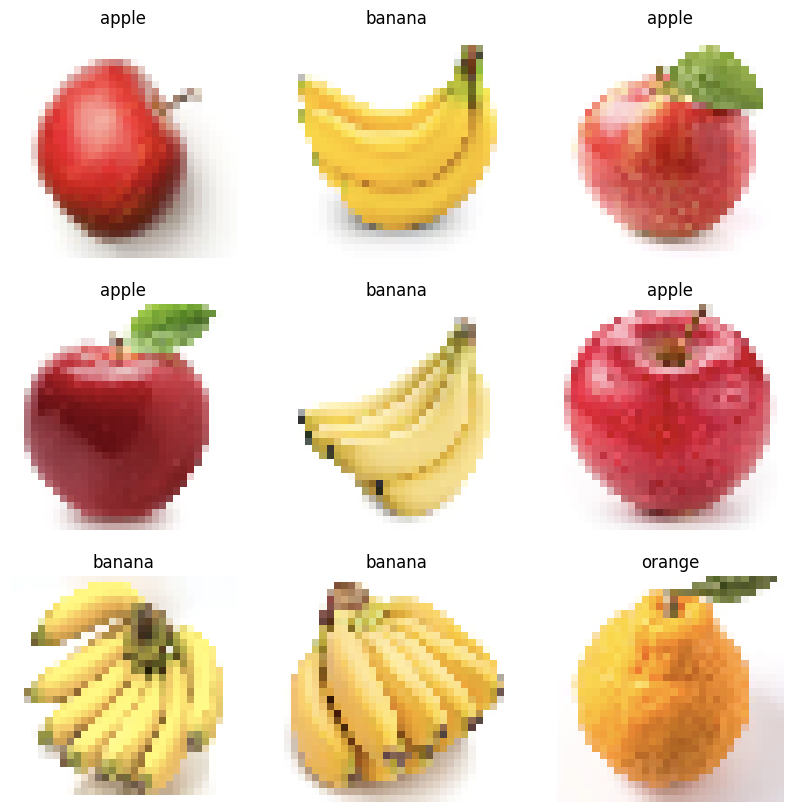

In [12]:
class_names = ["apple", "banana", "orange"]
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
model = tf.keras.Sequential(
    [
     tf.keras.layers.Rescaling(1./255),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(64, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(128, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation="softmax"),
     tf.keras.layers.Dense(3)
    ]
)

In [14]:
model.compile(
    optimizer="rmsprop",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics=['accuracy']
)

In [15]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 20
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.3633 - loss: 1.0982 - val_accuracy: 0.4848 - val_loss: 1.0962
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4262 - loss: 1.0887 - val_accuracy: 0.6364 - val_loss: 1.0319
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.5313 - loss: 1.0320 - val_accuracy: 0.6061 - val_loss: 0.9787
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.6007 - loss: 0.9881 - val_accuracy: 0.6061 - val_loss: 0.9582
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.6340 - loss: 0.9607 - val_accuracy: 0.4697 - val_loss: 1.0052
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7174 - loss: 0.9298 - val_accuracy: 0.8182 - val_loss: 0.8836
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.7591 - loss: 0.8993 - val_accuracy: 0.8182 - val_loss: 0.8786
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.8254 - loss: 0.8625 - val_accuracy: 0.8939 -

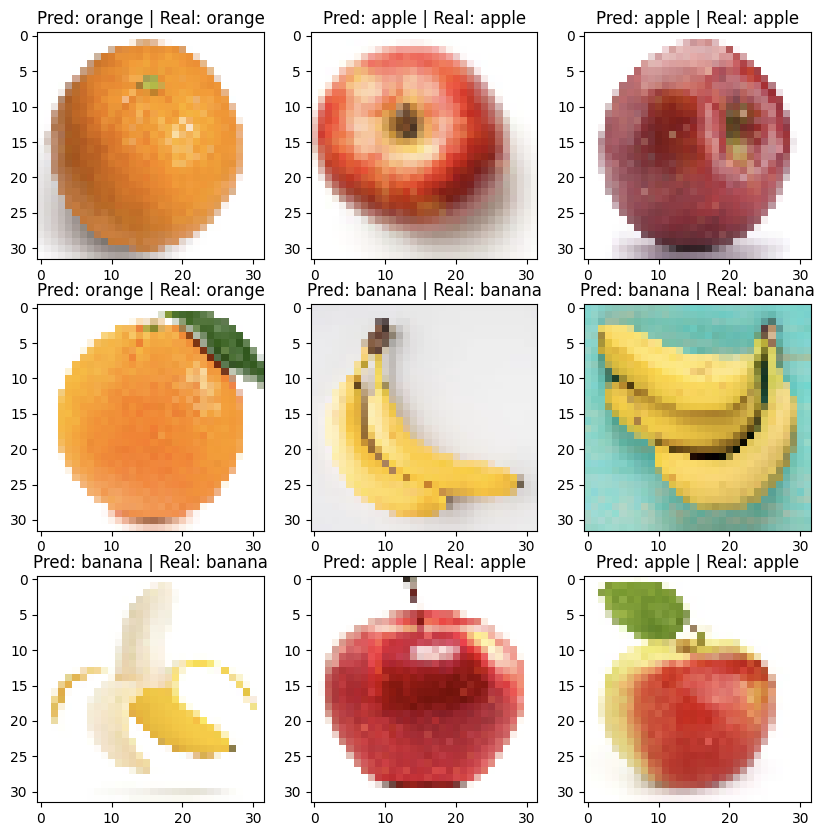

In [16]:
import numpy

plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
  classifications = model(images)
  # print(classifications)

  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = numpy.argmax(classifications[i])
    plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]])

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpn_ishza1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135902869284304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902869288528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902869288720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902869289680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902869289296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902869290256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902869289104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902869290832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902869289872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902564173008: TensorSpec(shape=(), dtype=tf.resource, name=None)
